<a href="https://colab.research.google.com/github/Bhavana0929/Amenity-Detection/blob/main/02-open-images-data-manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll start by downloading a few sample images, then build a little script which converts the samples to Detectron2 style before ramping it up.

In [ ]:
# Import Packages
import os
import pandas as pd
import random
import cv2

In [ ]:
# Install Detectron2 (locally)
import sys

In [ ]:
# Install PyTorch and torchvision
# You need to install PyTorch and torchvision first, as Detectron2 depends on them
!pip install torch torchvision

In [ ]:
import torch
import torchvision
#import detectron2

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
#print("Detectron2 version:", detectron2.__version__)

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


In [ ]:
# Install Cython and PyYAML
# Cython is used for compiling parts of the code, and PyYAML is used for configuration parsing.
!pip install cython pyyaml

In [ ]:
# Install COCO API
# The COCO API is another dependency, and it's installed via GitHub. This API is used for handling datasets in the COCO format.
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-d5n8fvzq
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-d5n8fvzq
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp311-cp311-linux_x86_64.whl size=399216 sha256=b80731c6a23d9b48874cf2fdbe3ad6797b828e133d1f4937db366b9ccedb8af6
  Stored in directory: /tmp/pip-ephem-wheel-cache-8vta54b8/wheels/6d/69/75/358c50a37672dfda8d74ba3b30ec49fb75d52f7c081886d503
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.8
    Uninstalling pycocotools-2.0.8:
      Successfully uninstalled pycocotools-2.0.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the f

In [ ]:
# Install Detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-8txud4r5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-8txud4r5
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
Using cached pycocotools-2.0.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (458 kB)
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [ ]:
import detectron2
print(detectron2.__version__)

0.6


In [ ]:
!gcc --version

gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Import Detectron2/requirements
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import os
import pandas as pd

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import torch/torchvision
import torch, torchvision
torch.__version__
!gcc --version

gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install wget,OpenCV,tqdm,awscli
!pip install wget

In [ ]:
!pip install opencv-python

In [ ]:
!pip install tqdm awscli

In [ ]:
# Download required meta-files for V5 - https://storage.googleapis.com/openimages/web/download.html

# # Training bounding boxes (1.11G)
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

# # Validating bounding boxes (23.94M)
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv

# # Testing bounding boxes (73.89M)
!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# # Class Names (11.73K)
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

--2025-01-29 22:45:11--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.91, 172.217.7.59, 172.217.12.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘train-annotations-bbox.csv’

train-annotations-b 100%[===================>]   1.11G  45.6MB/s    in 16s     

2025-01-29 22:45:28 (69.9 MB/s) - ‘train-annotations-bbox.csv’ saved [1194033454/1194033454]

--2025-01-29 22:45:28--  https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.91, 172.217.12.27, 172.217.15.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25105048 (24M) [text/csv]
Sav

In [ ]:
# Classes of amenities Airbnb mostly cares about
subset = ["Toilet",
          "Swimming_pool",
          "Bed",
          "Billiard_table",
          "Sink",
          "Fountain",
          "Oven",
          "Ceiling_fan",
          "Television",
          "Microwave_oven",
          "Gas_stove",
          "Refrigerator",
          "Kitchen_&_dining_room_table",
          "Washing_machine",
          "Bathtub",
          "Stairs",
          "Fireplace",
          "Pillow",
          "Mirror",
          "Shower",
          "Couch",
          "Countertop",
          "Coffeemaker",
          "Dishwasher",
          "Sofa_bed",
          "Tree_house",
          "Towel",
          "Porch",
          "Wine_rack",
          "Jacuzzi"]

In [ ]:
# To download the Open Images, using the following script:
!wget https://raw.githubusercontent.com/spmallick/learnopencv/refs/heads/master/downloadOpenImages/downloadOI.py

--2025-01-29 22:45:29--  https://raw.githubusercontent.com/spmallick/learnopencv/refs/heads/master/downloadOpenImages/downloadOI.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3555 (3.5K) [text/plain]
Saving to: ‘downloadOI.py’

downloadOI.py       100%[===================>]   3.47K  --.-KB/s    in 0s      

2025-01-29 22:45:30 (40.2 MB/s) - ‘downloadOI.py’ saved [3555/3555]



In [ ]:
!python3 downloadOI.py --classes 'Toilet,Swimming_pool,Bed,Billiard_table,Sink,Fountain,Oven,Ceiling_fan,Television,Microwave_oven,Gas_stove,Refrigerator,Kitchen_&_dining_room_table,Washing_machine,Bathtub,Stairs,Fireplace,Pillow,Mirror,Shower,Couch,Countertop,Coffeemaker,Dishwasher,Sofa_bed,Tree_house,Towel,Porch,Wine_rack,Jacuzzi' --mode validation

Class 0 : Toilet
Class 1 : Swimming_pool
Class 2 : Bed
Class 3 : Billiard_table
Class 4 : Sink
Class 5 : Fountain
Class 6 : Oven
Class 7 : Ceiling_fan
Class 8 : Television
Class 9 : Microwave_oven
Class 10 : Gas_stove
Class 11 : Refrigerator
Class 12 : Kitchen_&_dining_room_table
Class 13 : Washing_machine
Class 14 : Bathtub
Class 15 : Stairs
Class 16 : Fireplace
Class 17 : Pillow
Class 18 : Mirror
Class 19 : Shower
Class 20 : Couch
Class 21 : Countertop
Class 22 : Coffeemaker
Class 23 : Dishwasher
Class 24 : Sofa_bed
Class 25 : Tree_house
Class 26 : Towel
Class 27 : Porch
Class 28 : Wine_rack
Class 29 : Jacuzzi
Annotation Count : 1263
Number of images to be downloaded : 1047
  3% 35/1047 [00:32<16:52,  1.00s/it]sh: 1: _dining_room_table/0b6227bb06345402.jpg: not found
  6% 60/1047 [00:57<23:43,  1.44s/it]sh: 1: _dining_room_table/927e3a1efe86960a.jpg: not found
  7% 71/1047 [01:07<13:27,  1.21it/s]sh: 1: _dining_room_table/13cfe71ebbf0ae3b.jpg: not found
 11% 116/1047 [01:50<14:24,  1

[]

In [ ]:
def get_image_ids(image_folder=None):
    import os
    """
    Explores a folder of images and gets their ID from their file name.
    Returns a list of all image ID's in image_folder.
    E.g. image_folder/608fda8c976e0ac.jpg -> ["608fda8c976e0ac"]

    Params
    ------
    image_folder (str): path to folder of images, e.g. "../validation/"
    """
    img_ids = []
    for root, dirs, files in os.walk(image_folder):
         for file in files:
           if ".jpg" in file:
             # Get the full path of each file
             img_id = os.path.splitext(file)[0]
             img_ids.append(img_id)
    return img_ids

In [ ]:
val_image_ids = get_image_ids("validation")
val_image_ids

['829a698741377030',
 '2eeec709f51ecd0d',
 '00f3dbbbf5bdf2cf',
 '31448db4cd36ee82',
 'aeb082b467a2c39e',
 '58f48187d94f8419',
 '5b906e188aac9f24',
 'fd9ddaaed288ee16',
 '2b2c4fe6d63a13e4',
 'a8d7f65b1f6c2b76',
 '3f6e15958d41abf9',
 '8492e5d67d7ac44c',
 'c6bbe756d89aaacf',
 '3b1d6bb240a0ae42',
 '1050b3c3f36090a3',
 'd8cac8b54e9fa89c',
 'efb4560e129ba18d',
 'f7e5307116d5c3a7',
 'ec62b9d5a241a740',
 '1250a079d3fbd919',
 '51201063bfce5175',
 '0f731adcd7458c2b',
 '2a0905a2ff63f09e',
 'efa85d442d82b1d5',
 '477926ac3bcfb06e',
 '1ead457c867be1cd',
 'd6aeabaa3367dcaa',
 'e6d27669b2efb650',
 '115ca6aa3522da5a',
 'a04157ad11c879e2',
 'ee47ccab89a75d0d',
 'cfbec9a293d2ee73',
 '15f0965b63397a40',
 '9627e4edac0fc0f0',
 '5ba4992a5dec8a7a',
 '4c12b0b56d0064e0',
 '6e86e224c7e36481',
 '7bbc7a318dd0addb',
 'ceb70e14842006be',
 '6ad3d3e6690da1c8',
 'e7574843621495bd',
 '46afaf945caee54c',
 '2f7bb4d2d0b95fac',
 '8302f7352b501bc4',
 'fce8194fab48c500',
 '248b5f914b325928',
 '78767a54758dcd79',
 '9afab31afac

In [ ]:
len(val_image_ids)

1013

In [ ]:
# Make a function which formats a specific annotations csv based on what we're dealing with
def format_annotations(image_folder, annotation_file, target_classes=None):
    """
    TODO - NOTE: This function could (definitely can) be faster.
    TODO - Some ideas: skip the use of pandas entirely and use CSV's

    Formats annotation_file based on images contained in image_folder.
    Will get all unique image IDs and make sure annotation_file
    only contains those (the target images).
    Adds meta-data to annotation_file such as class names and categories.
    If target_classes isn't None, the returned annotations will be filtered by this list.
    Note: image_folder and annotation_file should both be validation if working on
    validation set or both be training if working on training set.

    Params
    ------
    image_folder (str): path to folder of target images.
    annotation_file (str): path to annotation file of target images.
    target_classes (list), optional: a list of target classes you'd like to filter labels.
    """
    # Get all image ids from target directory
    image_ids = get_image_ids(image_folder)

    # Setup annotation file and classnames
    annot_file = pd.read_csv(annotation_file)
    classes = pd.read_csv("class-descriptions-boxable.csv",
                          names=["LabelName", "ClassName"])

    # Create classname column on annotations which converts label codes to string labels
    annot_file["ClassName"] = annot_file["LabelName"].map(classes.set_index("LabelName")["ClassName"])

    # Make sure we only get the images we're concerned about
    if target_classes:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids) & annot_file["ClassName"].isin(target_classes)]
    else:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids)]

    # Add ClassID column, e.g. "Bathtub, Toilet" -> 1, 2
    annot_file["ClassID"] = pd.Categorical(annot_file["ClassName"]).codes

    return annot_file

In [ ]:
val_annot = format_annotations("validation", "validation-annotations-bbox.csv")
val_annot.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
427,0052ea56ee869426,xclick,/m/018xm,1,0.000000,0.337500,0.033333,0.835417,0,1,0,0,0,Ball,3
428,0052ea56ee869426,xclick,/m/018xm,1,0.526563,0.848437,0.229167,0.658333,0,0,0,0,0,Ball,3
429,0052ea56ee869426,xclick,/m/04bcr3,1,0.000000,1.000000,0.366667,1.000000,0,1,0,0,0,Table,161
430,0052ea56ee869426,xclick,/m/05y5lj,1,0.001563,1.000000,0.368750,1.000000,0,1,0,0,0,Sports equipment,149
431,0052ea56ee869426,xclick,/m/05y5lj,1,0.439063,0.526563,0.302083,0.377083,0,0,0,0,0,Sports equipment,149


In [ ]:
val_annot = format_annotations("validation", "validation-annotations-bbox.csv", target_classes=subset)
val_annot.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
599,007f71665b0812a7,xclick,/m/07c52,1,0.000000,1.000000,0.000000,1.000000,0,0,0,0,0,Television,17
1136,00ec4ba83d648c33,xclick,/m/07c52,1,0.050000,0.997917,0.100000,0.902778,0,1,0,0,0,Television,17
1195,00f3dbbbf5bdf2cf,xclick,/m/02crq1,1,0.000000,0.460289,0.521661,0.904332,0,1,0,0,0,Couch,3
4222,03646bb2f288eaae,xclick,/m/03ssj5,1,0.000000,0.998523,0.222958,0.997792,1,1,0,0,0,Bed,1
5161,0477154c66e5ddcb,xclick,/m/040b_t,1,0.082828,0.949495,0.071082,0.933764,0,0,0,0,0,Refrigerator,13


In [ ]:
len(val_annot)

801

In [ ]:
val_annot["ClassName"].value_counts()

,count
ClassName,
Bed,125
Pillow,76
Countertop,68
Couch,61
Sink,57
Porch,52
Stairs,45
Television,44
Fireplace,41


In [ ]:
bbox = np.array([0.27286136, 0.40486726, 0.84070796, 1.        ])
bbox[0] = np.multiply(bbox[0], 100)
bbox

array([27.286136  ,  0.40486726,  0.84070796,  1.        ])

In [ ]:
# Write function to convert bounding boxes from relative to absolute
# Takes in x0, y0, x1, y1, height and width and converts from relative to absolute
def rel_to_absolute(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode

    Params
    ------
    bbox (array): relative dimensions of bounding box in format (x0, y0, x1, y1 or Xmin, Ymin, Xmax, Ymax)
    height (int): height of image
    width (int): width of image
    """
    bbox[0] = np.multiply(bbox[0], width) # x0
    bbox[1] = np.multiply(bbox[1], height) # y0
    bbox[2] = np.multiply(bbox[2], width) # x1
    bbox[3] = np.multiply(bbox[3], height) # y1
    return bbox

In [ ]:
bbox_abs = rel_to_absolute(bbox, 100, 200)
bbox_abs

array([5457.2272  ,   40.486726,  168.141592,  100.      ])

In [ ]:
# Import CV2 for getting height & width of image
import cv2

# Import Detectron2 BoxMode for bounding boxes style
from detectron2.structures import BoxMode

In [ ]:
def get_image_filenames(image_folder):
  import os
  img_filenames = []
  for root, dirs, files in os.walk(image_folder):
    for file in files:
      if ".jpg" in file:
        # Get the full path of each file
        img_filename = os.path.join(root, file)
        img_filenames.append(img_filename)
  return img_filenames

In [ ]:
img_filenames = get_image_filenames("validation")
len(img_filenames)

1013

In [ ]:
img_filenames[:5]

['validation/Couch/829a698741377030.jpg',
 'validation/Couch/2eeec709f51ecd0d.jpg',
 'validation/Couch/00f3dbbbf5bdf2cf.jpg',
 'validation/Couch/31448db4cd36ee82.jpg',
 'validation/Couch/aeb082b467a2c39e.jpg']

In [ ]:
val_image_ids[:5]

['829a698741377030',
 '2eeec709f51ecd0d',
 '00f3dbbbf5bdf2cf',
 '31448db4cd36ee82',
 'aeb082b467a2c39e']

In [ ]:
# Next: functionise the below code
def get_image_dicts(image_folder):
    """
    Returns Detectron2 style labels of images in image_folder based on data in annotations.

    TODO -- Maybe create some verbosity here? AKA, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?

    Params
    ------
    image_folder (str): target folder containing images
    annotations (DataFrame): DataFrame of image label data
    """
    # Get annotations (automatically picks annotations CSV based on image_folder)
    annotations = format_annotations(image_folder,
                                     image_folder+"-annotations-bbox.csv",
                                     target_classes=subset) # TODO: this uses a global variable

    # Get all unique image ids from target folder
    img_ids = get_image_ids(image_folder)
    img_filenames = get_image_filenames(image_folder)

    my_dict = dict(zip(img_ids, img_filenames))

    # Start creating image dictionaries (Detectron2 style labelling)
    img_dicts = []
    for img_id,img_filename in my_dict.items():
        record = {}

        # Get image metadata
        file_name = img_filename
        img = img_id
        height, width = cv2.imread(file_name).shape[:2]
        img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images
                                                                            # with multiple objects
        # Update record dictionary
        record["file_name"] = file_name
        record["image_id"] = img
        record["height"] = height
        record["width"] = width

        # Create list of image annotations (labels)
        img_annotations = []
        for i in range(len(img_data)): # this is where we loop through examples with multiple objects in an image
            category_id = img_data.loc[i]["ClassID"]
            # Get bounding box coordinates in Detectron2 style (x0, y0, x1, y1)
            bbox = np.float32(img_data.loc[i][["XMin", "YMin", "XMax", "YMax"]].values) # needs to be float/int
            # Convert bbox from relative to absolute pixel dimensions
            bbox = rel_to_absolute(bbox=bbox, height=height, width=width)
            # Setup annot (1 annot = 1 label, there might be more) dictionary
            annot = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS, # See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode.XYXY_ABS
                "category_id": category_id
            }
            img_annotations.append(annot)

        # Update record dictionary with annotations
        record["annotations"] = img_annotations

        # Add record dictionary with image annotations to img_dicts list
        img_dicts.append(record)
    return img_dicts

In [ ]:
val_img_dicts = get_image_dicts("validation")
len(val_img_dicts)

833

In [ ]:
# Check labels for random image
# TODO - make this visual
import random
number = round(random.randint(0, len(val_img_dicts)))
print(number)
val_img_dicts[number]

273


{'file_name': 'validation/Stairs/45ed28848e14e7e2.jpg',
 'image_id': '45ed28848e14e7e2',
 'height': 768,
 'width': 1024,
 'annotations': [{'bbox': array([  12.8,  521.6, 1024. ,  768. ], dtype=float32),
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 16},
  {'bbox': array([   0.     ,  494.40002, 1024.     ,  768.     ], dtype=float32),
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 12}]}

In [ ]:
val_annot.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
154433,82ed3a2de7df67a8,xclick,/m/03dnzn,1,0.143750,0.882812,0.427083,0.997917,1,1,0,0,0,Bathtub,0
153443,822f20d881eebeb9,xclick,/m/03dnzn,1,0.000000,1.000000,0.181250,0.962500,0,0,0,0,0,Bathtub,0
25061,15348e4f2c7ebe0f,xclick,/m/03dnzn,1,0.086643,1.000000,0.601083,1.000000,0,0,0,0,0,Bathtub,0
154965,837b3d11ff02f116,xclick,/m/03dnzn,1,0.000000,0.669616,0.373894,1.000000,0,1,0,0,0,Bathtub,0
281915,eccb080e57b2aac5,xclick,/m/03dnzn,1,0.302941,0.905882,0.470067,1.000000,0,0,0,0,0,Bathtub,0


In [ ]:
val_annot = val_annot.sort_values("ClassID")

In [ ]:
val_annot

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
154433,82ed3a2de7df67a8,xclick,/m/03dnzn,1,0.143750,0.882812,0.427083,0.997917,1,1,0,0,0,Bathtub,0
153443,822f20d881eebeb9,xclick,/m/03dnzn,1,0.000000,1.000000,0.181250,0.962500,0,0,0,0,0,Bathtub,0
25061,15348e4f2c7ebe0f,xclick,/m/03dnzn,1,0.086643,1.000000,0.601083,1.000000,0,0,0,0,0,Bathtub,0
154965,837b3d11ff02f116,xclick,/m/03dnzn,1,0.000000,0.669616,0.373894,1.000000,0,1,0,0,0,Bathtub,0
281915,eccb080e57b2aac5,xclick,/m/03dnzn,1,0.302941,0.905882,0.470067,1.000000,0,0,0,0,0,Bathtub,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,093cf2c963e1fa76,xclick,/m/0162_1,1,0.100295,1.000000,0.061947,1.000000,0,1,0,0,0,Towel,19
33580,1c3e59d9e6191378,xclick,/m/0162_1,1,0.018634,1.000000,0.000000,0.989496,0,1,0,0,0,Towel,19
12507,0aa01b6843d9e158,xclick,/m/0162_1,1,0.525000,0.920833,0.062500,0.778125,0,0,0,0,0,Towel,19
41526,2305e785c4e0bf51,xclick,/m/0162_1,1,0.237113,0.313697,0.800885,0.995575,0,1,0,0,0,Towel,19


In [ ]:
things = val_annot.set_index("ClassID").to_dict()["ClassName"]
thing_list = list(things.values())
thing_list

['Bathtub',
 'Bed',
 'Coffeemaker',
 'Couch',
 'Countertop',
 'Dishwasher',
 'Fireplace',
 'Fountain',
 'Jacuzzi',
 'Mirror',
 'Oven',
 'Pillow',
 'Porch',
 'Refrigerator',
 'Shower',
 'Sink',
 'Stairs',
 'Television',
 'Toilet',
 'Towel']

In [ ]:
# Register Data in Detectron2 style
from detectron2.data import DatasetCatalog, MetadataCatalog

In [ ]:
for d in ["validation"]:
    # dataset_name, mapper function
    DatasetCatalog.register(d + "_dataset", lambda d=d: get_image_dicts(d))
    MetadataCatalog.get(d + "_dataset").set(thing_classes=thing_list)
val_metadata = MetadataCatalog.get("validation_dataset")

In [ ]:
MetadataCatalog.list()

['coco_2014_train',
 'coco_2014_val',
 'coco_2014_minival',
 'coco_2014_valminusminival',
 'coco_2017_train',
 'coco_2017_val',
 'coco_2017_test',
 'coco_2017_test-dev',
 'coco_2017_val_100',
 'keypoints_coco_2014_train',
 'keypoints_coco_2014_val',
 'keypoints_coco_2014_minival',
 'keypoints_coco_2014_valminusminival',
 'keypoints_coco_2017_train',
 'keypoints_coco_2017_val',
 'keypoints_coco_2017_val_100',
 'coco_2017_train_panoptic_separated',
 'coco_2017_train_panoptic_stuffonly',
 'coco_2017_train_panoptic',
 'coco_2017_val_panoptic_separated',
 'coco_2017_val_panoptic_stuffonly',
 'coco_2017_val_panoptic',
 'coco_2017_val_100_panoptic_separated',
 'coco_2017_val_100_panoptic_stuffonly',
 'coco_2017_val_100_panoptic',
 'lvis_v1_train',
 'lvis_v1_val',
 'lvis_v1_test_dev',
 'lvis_v1_test_challenge',
 'lvis_v0.5_train',
 'lvis_v0.5_val',
 'lvis_v0.5_val_rand_100',
 'lvis_v0.5_test',
 'lvis_v0.5_train_cocofied',
 'lvis_v0.5_val_cocofied',
 'cityscapes_fine_instance_seg_train',
 'city

In [ ]:
val_metadata

namespace(name='validation_dataset',
          thing_classes=['Bathtub',
                         'Bed',
                         'Coffeemaker',
                         'Couch',
                         'Countertop',
                         'Dishwasher',
                         'Fireplace',
                         'Fountain',
                         'Jacuzzi',
                         'Mirror',
                         'Oven',
                         'Pillow',
                         'Porch',
                         'Refrigerator',
                         'Shower',
                         'Sink',
                         'Stairs',
                         'Television',
                         'Toilet',
                         'Towel'])

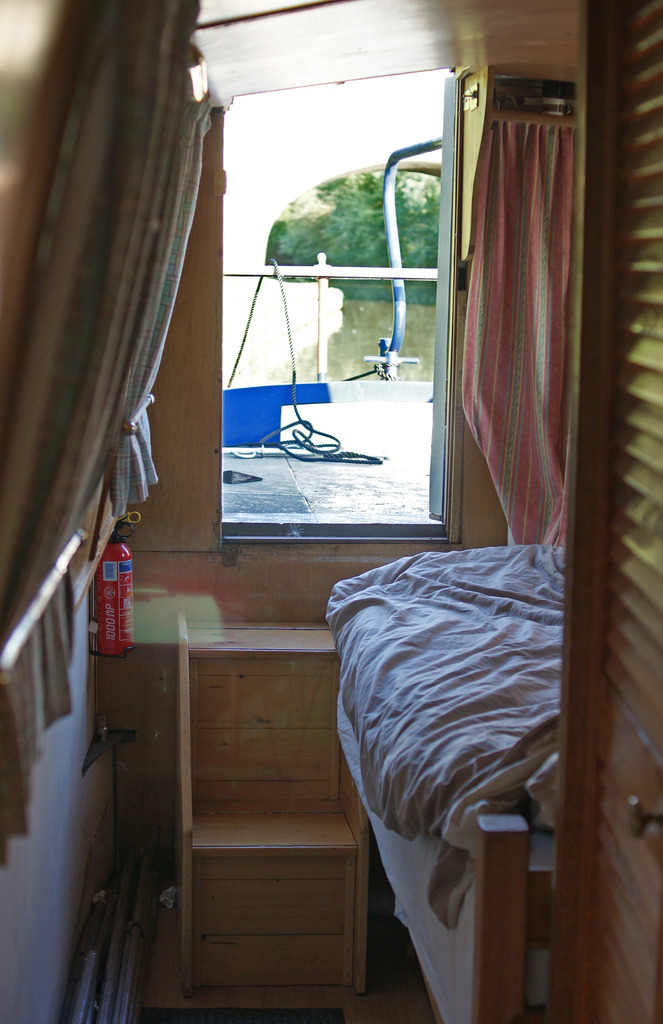

In [ ]:
from IPython.display import Image
Image("validation/Bed/968d0022f4b1d0dc.jpg")

In [ ]:
# Make a function to view images
def view_images(image_dict, random_image=True, n_images=1):
    plt.figure(figsize=(30,30))
    if random_image:
        for i, d in enumerate(random.sample(image_dict, n_images)):
            img=cv2.imread(d["file_name"])
            visualizer = Visualizer(img[:, :, :],
                            metadata=val_metadata,
                            scale=0.6)
            vis = visualizer.draw_dataset_dict(d)
            ax = plt.subplot(n_images, 1, i+1)
            plt.imshow(vis.get_image()[:, :, ::-1])
            plt.axis("off")

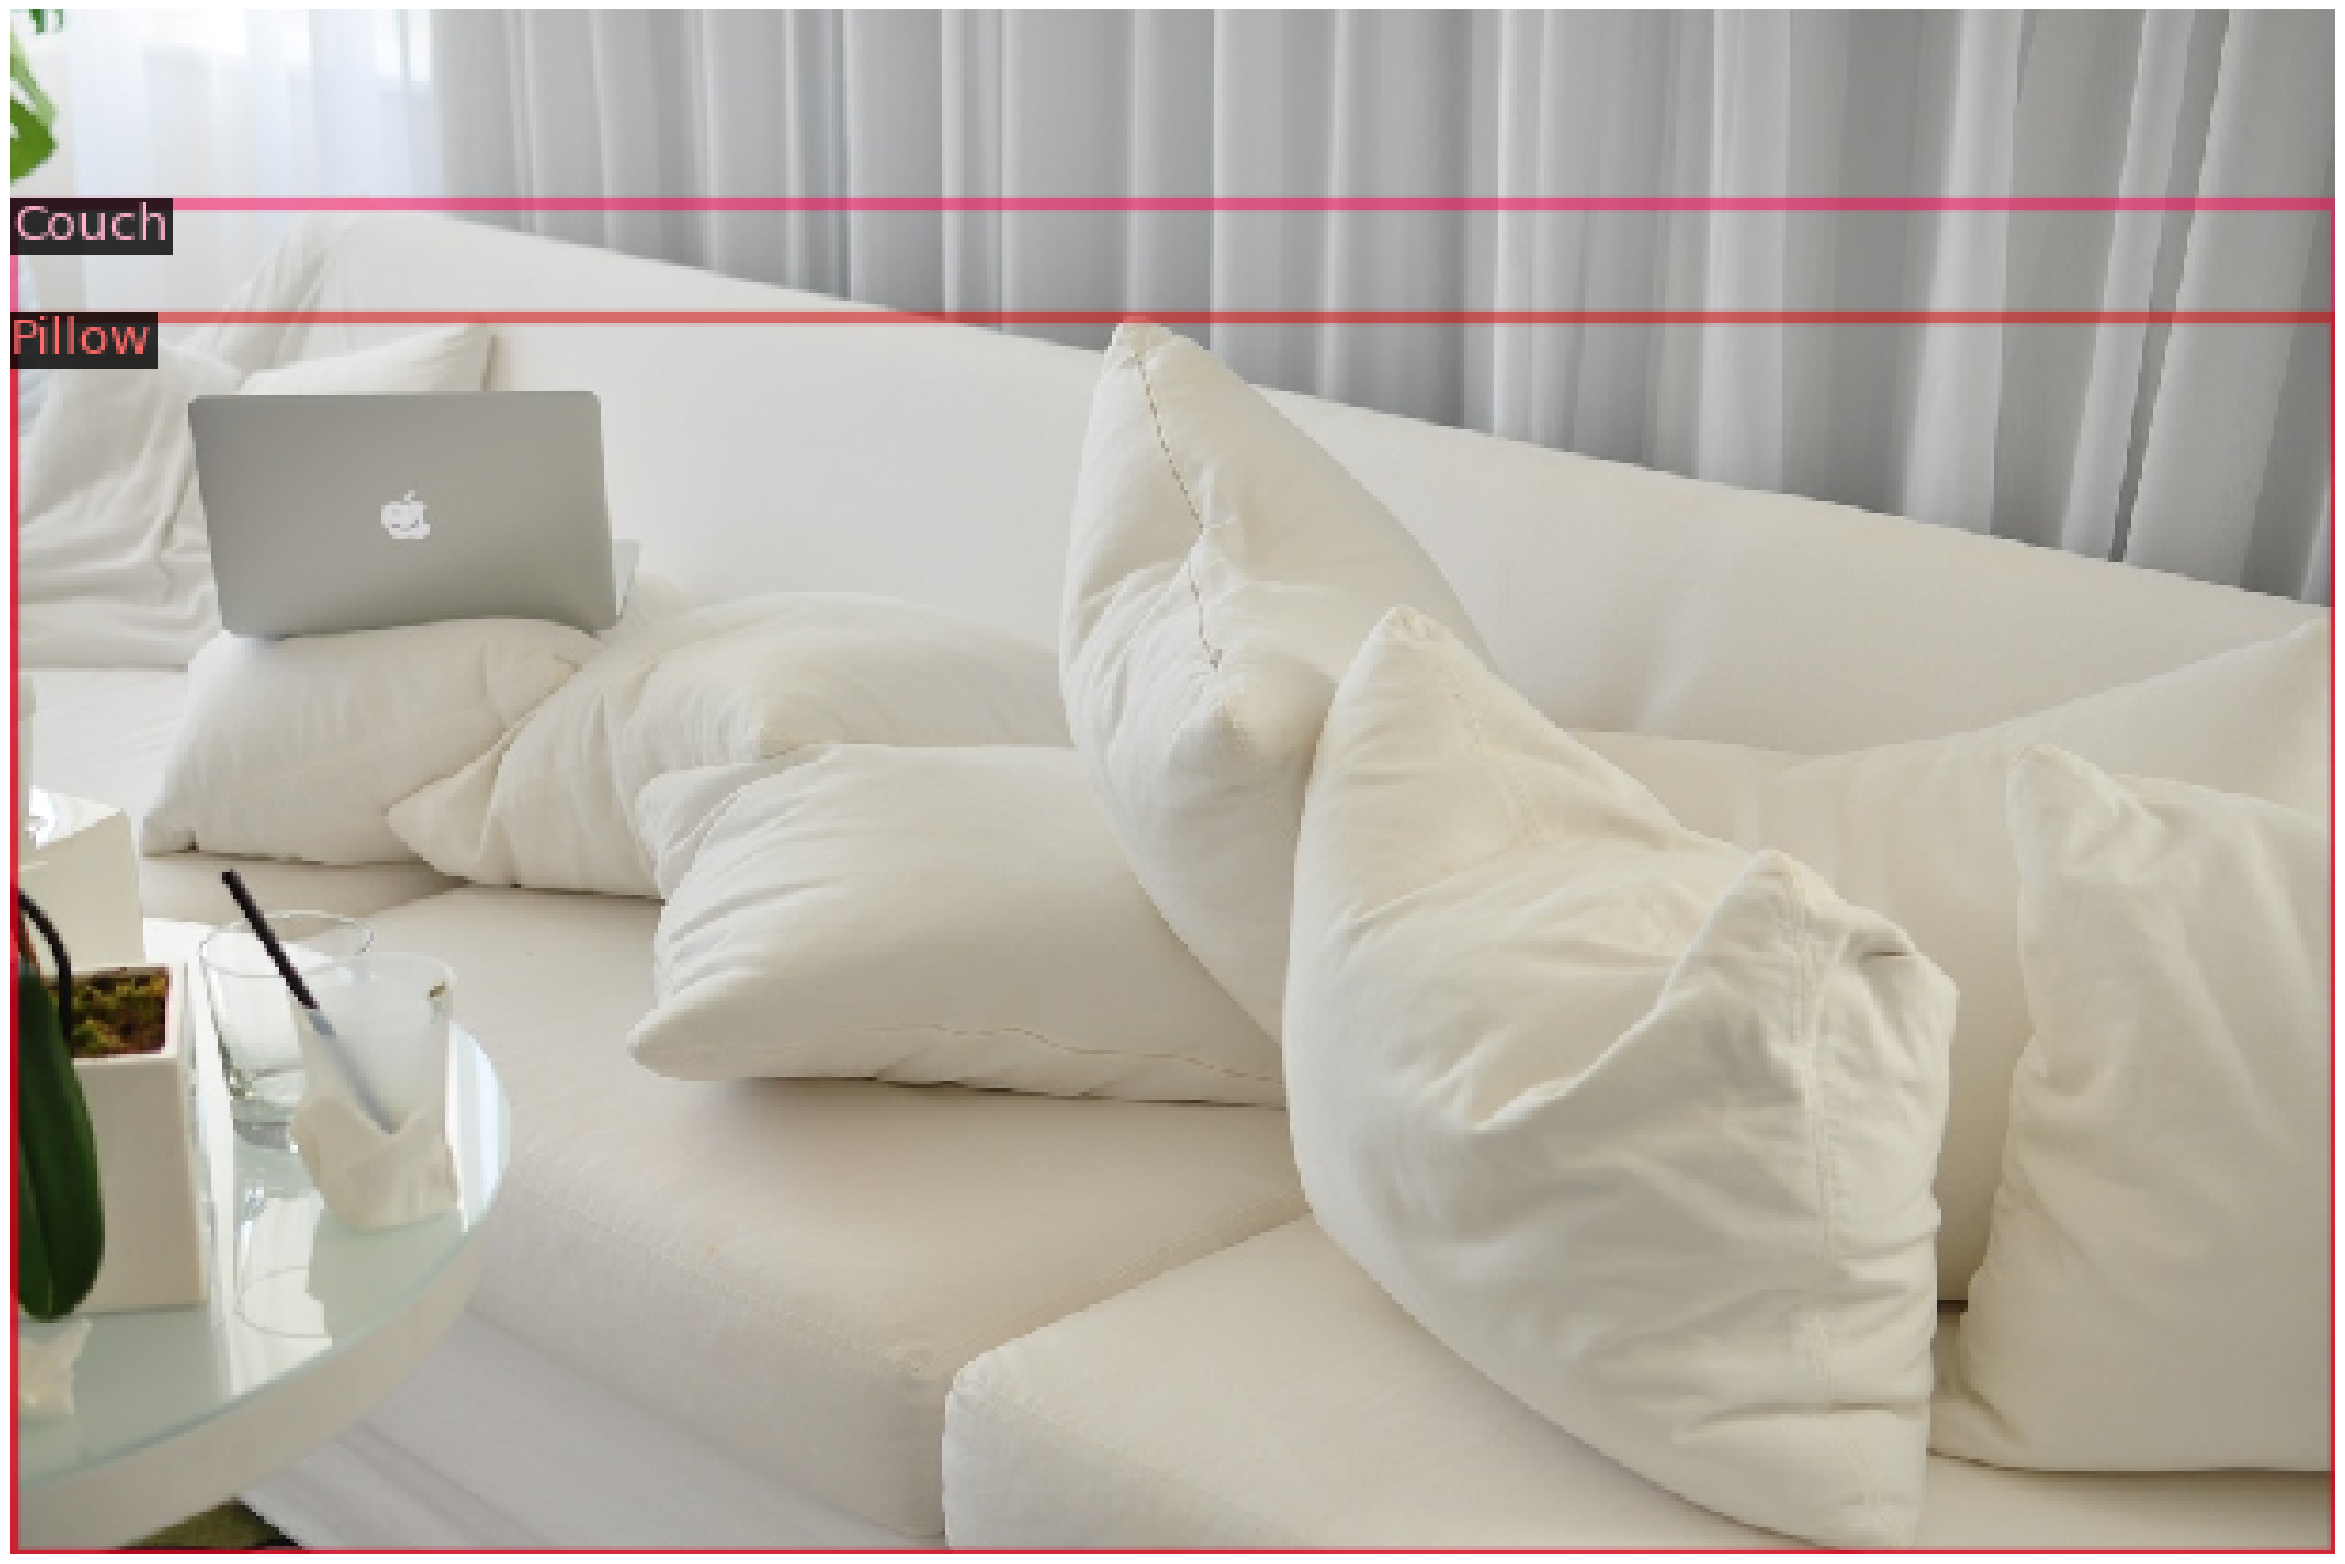

In [ ]:
view_images(val_img_dicts)